# Neo4j Netflix Network  
A recommendation system for Netflix-like data using users, movies, reviews, and watch history.  This notebook builds a graph-based recommendation engine for Netflix-like data using Neo4j GDS algorithms such as PageRank, Link Prediction, and Node Similarity.

---

## 1. Introduction  

#### Objective  
The goal of this notebook is to build a **recommendation system for Netflix users** by leveraging graph-based algorithms implemented in **Neo4j Graph Data Science (GDS)**.  
Instead of only relying on traditional collaborative filtering, we represent users, movies, and their interactions as a **graph**, enabling us to run algorithms such as **PageRank, Link Prediction, and Similarity Measures** to generate recommendations.  

---

#### Dataset  

- **Input files:** `users.csv`, `watch_history.csv`, `movies.csv`, `reviews.csv`  
- **Source:** [Netflix User Behavior Dataset (Kaggle)](https://www.kaggle.com/datasets/sayeeduddin/netflix-2025user-behavior-dataset-210k-records)  

---

#### Graph Schema  

- **Nodes:** `Movie`, `Genre`, `User`  
- **Relationships:**  
  1. `(User)-WATCHED->(Movie)` from `watch_history.csv`  
  2. `(User)-RATED->(Movie)` from `reviews.csv`  
  3. `(Movie)-BELONGS_TO->(Genre)` from `movies.csv`

The following diagram (exported from Neo4j) shows the labels (`User`, `Movie`, `Genre`) and relationships:  

![Graph Schema](https://dl.dropboxusercontent.com/scl/fi/86hyb41zqycwyb6yn3pu1/Label_Graph_Visualisation.png?rlkey=viyf06m9vmhou46gcyry70yzo&st=t2cp1f6c)


---

#### Workflow  

1. Import dataset  
2. Load into Neo4j database and create constraints  
3. Project graph into Neo4j GDS  
4. Run algorithms:  
   - **PageRank** → Find influential movies  
   - **Similarity (Jaccard/Cosine)** → Find users with similar preferences  
   - **Link Prediction** → Predict likely new edges (ratings)  
5. Generate personalized movie recommendations for each user  
6. Evaluate results and visualize  

---

#### Requirements  

- **Neo4j Desktop** or **Neo4j Sandbox** running  
- Python packages:  
  - `py2neo`  
  - `networkx`  
  - `matplotlib`  
  - `pandas`  


In [1]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Connect
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("UserId", "password"))
print("Driver initialized successfully")


Driver initialized successfully


## 2. Data Loading and Graph Preparation  

#### 🔹 Neo4j-Specific Preprocessing  

Before running graph algorithms, we need to **import the CSV files into Neo4j** and prepare the graph structure.  

**Steps:**  
1. **Create Constraints & Indexes**  
   - Ensure uniqueness of nodes (`User`, `Movie`, `Genre`) for efficient loading.  

2. **Load CSV Data**  
   - `users.csv` → Create `(:User)` nodes  
   - `movies.csv` → Create `(:Movie)` nodes and link to `(:Genre)`  
   - `watch_history.csv` → Create `(:User)-[:WATCHED]->(:Movie)` relationships  
   - `reviews.csv` → Create `(:User)-[:RATED {rating: ...}]->(:Movie)` relationships  
---



In [2]:
# Query
with driver.session() as session:
    # --- Create uniqueness constraints ---
    session.run("""
        CREATE CONSTRAINT movie_unique IF NOT EXISTS
        FOR (m:Movie) REQUIRE m.ID IS UNIQUE
    """)
    session.run("""
        CREATE CONSTRAINT user_id_unique IF NOT EXISTS
        FOR (u:User) REQUIRE u.ID IS UNIQUE
    """)
    session.run("""
        CREATE CONSTRAINT genre_name_unique IF NOT EXISTS
        FOR (g:Genre) REQUIRE g.Name IS UNIQUE
    """)

    print("✅ Constraints created successfully.")
    # --- Load Movies and Genres from CSV ---
    session.run("""
        LOAD CSV WITH HEADERS FROM 'https://www.dropbox.com/scl/fi/osfhw6liiknrigww2hk7h/movies.csv?rlkey=feqaov951krn6pbn94iasekzo&st=o3lz6f5j&dl=1' AS row
        MERGE (m:Movie {ID: row.movie_id}) 
        SET m.title = row.title,
            m.genre =  row.genre_primary, 
            m.release_year = toInteger(row.release_year), 
            m.language = row.language, 
            m.country = row.country_of_origin,
            m.imdb_rating = CASE WHEN row.imdb_rating <> '' THEN toFloat(row.imdb_rating) END
        WITH m, row
        MERGE (g:Genre {Name: row.genre_primary})
        MERGE (m)-[:BELONGS_TO]->(g)
    """)
    print("📚 Movies loaded.")
    # --- Load Users from CSV ---
    session.run("""
        LOAD CSV WITH HEADERS FROM 'https://www.dropbox.com/scl/fi/16tzqf7vnckb67sy69xf5/users.csv?rlkey=delyvfecwgxfhi1dwyuulvjd1&st=08qf1iks&dl=1' AS row
        merge (u:User{ID:row.user_id, first_name:row.first_name, last_name:row.last_name})
        SET u.age=toInteger(row.age), 
            u.gender = CASE WHEN row.gender <> '' THEN row.gender END, 
            u.country = CASE WHEN row.country <> '' THEN row.country END
        """)
    print("⭐ Users loaded.")
    


✅ Constraints created successfully.
📚 Movies loaded.
⭐ Users loaded.


In [3]:
 # ---  Load User Ratings ---
 with driver.session() as session:
    session.run("""
            LOAD CSV WITH HEADERS FROM 'https://www.dropbox.com/scl/fi/hdnnp1753tppq9z4le0gw/reviews.csv?rlkey=hukoat0h98r7j3evyf5hptbtb&st=ewfkr496&dl=1' AS row
            MATCH (u:User{ID:row.user_id}), (m:Movie{ID:row.movie_id})
            MERGE (u)-[r:RATED{rating:toFloat(row.rating)}]->(m)
            SET r.review_text =  CASE WHEN row.review_text <> '' THEN row.review_text END 
            SET r.sentiment =  CASE WHEN row.sentiment <> '' THEN row.sentiment END 
            """)
    print("⭐ Ratings loaded.")


⭐ Ratings loaded.


In [4]:
 # --- Load User Watch history ---
 with driver.session() as session:
    session.run("""
            LOAD CSV WITH HEADERS FROM 'https://www.dropbox.com/scl/fi/vdjnxmolcmnl6l07qn1q6/watch_history.csv?rlkey=c5049zpmzc35d015bpteqys8s&st=94pblm6t&dl=1' AS row
            MATCH (u:User{ID:row.user_id}), (m:Movie{ID:row.movie_id})
            where row.action = "completed" 
            MERGE (u)-[r:WATCHED]->(m)
            """)
    print("⭐ Watch History loaded.")


⭐ Watch History loaded.


---
## 3. Exploratory Data Analysis (EDA)

Before diving into graph algorithms, it’s useful to perform some **basic exploratory analysis** to understand the dataset.  

#### 🔹 Goals of EDA  
- Get an overview of the **ratings distribution**  
- Understand the **activity levels of users**  
- Identify **popular movies** based on ratings and watch counts  

---




#### 3.1 Basic Statistics
- **Number of Users (nodes):** X  
- **Number of Movies (nodes):** Y  
- **Number of Relationships (`RATED`):** Z  

📌 *This provides a quick sanity check on the dataset size and ensures the graph was loaded correctly.*  

---


In [5]:
with driver.session() as session:
    rel_counts = session.run("""
        MATCH (u:User)
        WITH count(u) AS users
        MATCH (g:Genre)
        WITH users, COUNT(g) AS genres
        MATCH (m:Movie)
        WITH users, genres, count(m) AS movies
        MATCH (:User)-[r:RATED]->(:Movie)
        WITH users, genres, movies, count(r) AS U_M_rels
        MATCH (:Movie)-[q:BELONGS_TO]->(:Genre)
        WITH users, genres, movies,U_M_rels, count(q) AS M_G_rels
        MATCH (:User)-[p:WATCHED]->(:Movie)
        return users, genres, movies,U_M_rels, M_G_rels, count(p) AS watched_count;
        """)
    record = rel_counts.single()

    # Print values nicely
    print("Users:", record["users"])
    print("Genres:", record["genres"])
    print("Movies:", record["movies"])
    print("No of User Movie relations",record["U_M_rels"])
    print("No of Movie Genre relations",record["M_G_rels"])
    print("No of Watch relations",record["watched_count"])
    
        

Users: 10000
Genres: 20
Movies: 1000
No of User Movie relations 14996
No of Movie Genre relations 1000
No of Watch relations 24796



### 3.2 Movie Popularity
- Identify top-rated movies  
- Most Active Users

---


In [6]:
with driver.session() as session:
    result = session.run("""
        MATCH (m:Movie)
        WHERE m.imdb_rating is Not NULL
        return m.title as title, m.imdb_rating AS rating
            ORDER BY rating DESC
            LIMIT 20
        """)
    for record in result:
        print(record["title"], record["rating"])

Our Night 10.0
Storm Mystery 10.0
Dream Warrior 10.0
Dark Ice 10.0
Last Night 10.0
A Quest 10.0
My Story 10.0
Last Ice 10.0
First Dream 10.0
Story Warrior 10.0
Bright War 9.9
Secret Mystery 9.8
City Queen 9.7
Journey King 9.7
Story Legend 9.6
Day City 9.6
Love Fire 9.5
First Storm 9.5
Legend King 9.5
Dragon Day 9.5


In [7]:
with driver.session() as session:
    result = session.run("""
        MATCH (u:User)-[w:WATCHED]->(m:Movie)
        return u.ID as user, u.first_name as f_name, u.last_name as l_name,
            count(w) AS watched_movies
            ORDER BY watched_movies DESC
            LIMIT 20
        """)
    for record in result:
        print(record["user"], record["f_name"], record["l_name"], record["watched_movies"])

user_08413 Kayla Quinn 10
user_05244 Sandra Jennings 10
user_07527 Elizabeth Brown 9
user_00490 Charles Campbell 9
user_02549 Steven Morris 9
user_07910 Aaron Spencer 9
user_07098 Blake Lambert 9
user_08877 Walter Williams 9
user_07477 Matthew Harris 8
user_08706 Christina Hernandez 8
user_08299 Stephen Gutierrez 8
user_07237 Sara Allen 8
user_08956 Elizabeth Yang 8
user_08072 Jonathan Weeks 8
user_01687 Kimberly Mitchell 8
user_00462 Christopher Reeves 8
user_09610 Richard Haas 8
user_06104 Ryan Fitzgerald 8
user_00387 Nancy Holloway 8
user_05089 Richard Moore 8


### 3.3 Visual Exploration
- **Distribution of Ratings:** Histogram of rating values (1–5 scale)  
- **Graph Snapshot:** Visualize a small subgraph of users and movies to get an intuition for connectivity  
- **Bipartite Graph Preview:** Visualize a subset of the **User–Movie bipartite graph** to confirm connectivity patterns.  
---


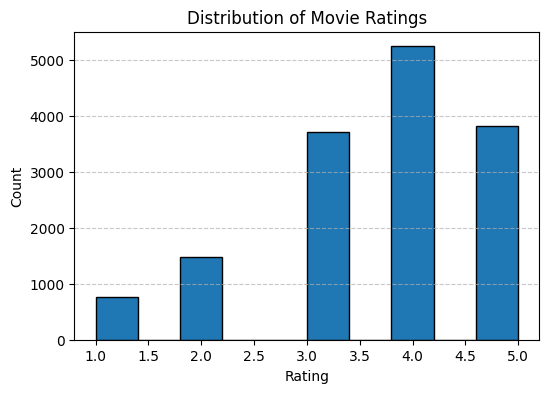

In [8]:
#Distribution of ratings.
# Collect all ratings from Neo4j
with driver.session() as session:
    result = session.run("""
        MATCH (:User)-[r:RATED]->(:Movie)
        RETURN r.rating AS rating
    """)
    ratings = [record["rating"] for record in result]

# Plot histogram (distribution of ratings)
plt.figure(figsize=(6,4))
plt.hist(ratings, bins=10, edgecolor="black")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


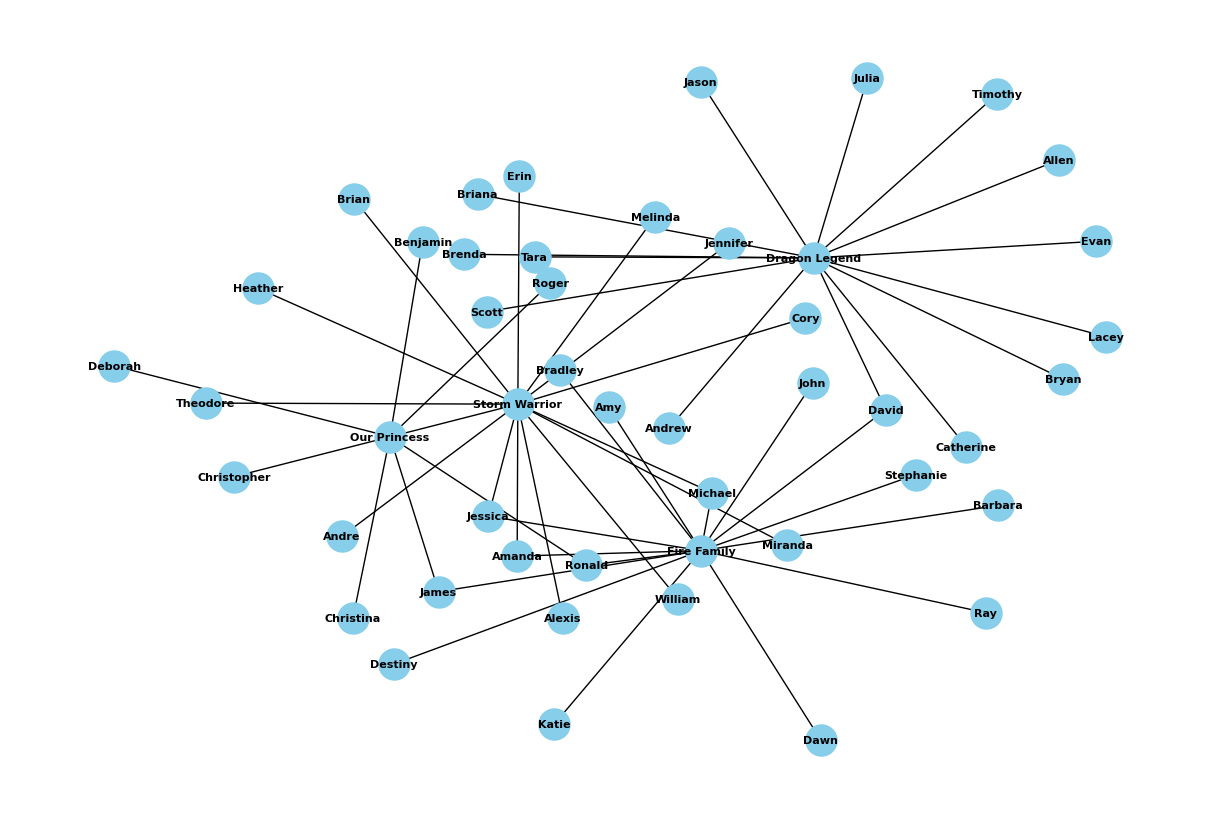

USER-RATED-MOVIE graph


In [9]:
G = nx.Graph()
with driver.session() as session:
    result = session.run("""
        MATCH (u:User)-[r:RATED]->(m:Movie)
        RETURN m.title AS movie, u.first_name AS user, r.rating as rating
        LIMIT 50
    """)

    for record in result:
        movie = record["movie"]
        user = record["user"]
        G.add_node(movie, bipartite=0)
        G.add_node(user, bipartite=1)
        G.add_edge(user, movie)
        
# Draw
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=8, font_weight="bold")
plt.show()
print("USER-RATED-MOVIE graph")

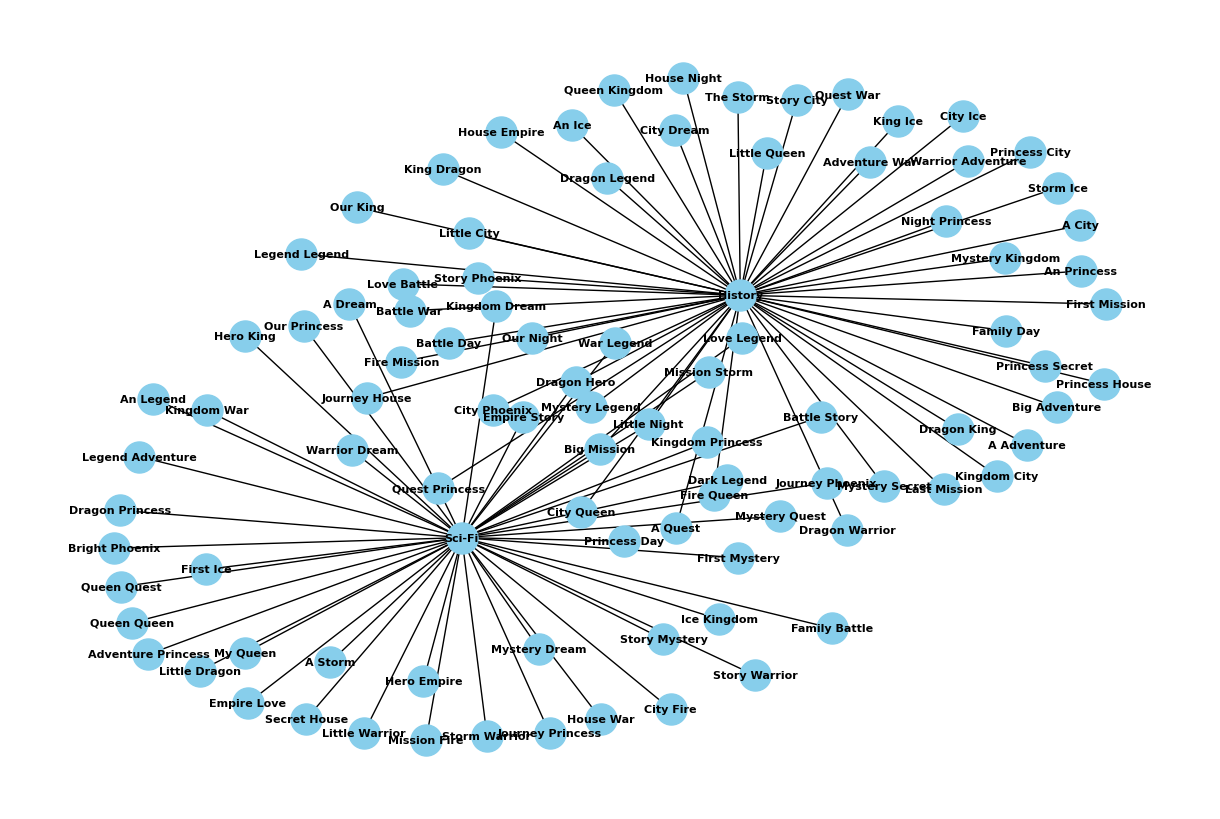

MOVIE-BELONGS_TO-GENRE graph


In [10]:
G = nx.Graph()
with driver.session() as session:
    result = session.run("""
        MATCH (m:Movie)-[q:BELONGS_TO]->(g:Genre)
        RETURN m.title AS movie, g.Name as genre
        LIMIT 100
        """)

    for record in result:
        movie = record["movie"]
        genre = record["genre"]
        G.add_node(movie, bipartite=0)
        G.add_node(genre, bipartite=1)
        G.add_edge(movie, genre)

# Draw
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=8, font_weight="bold")
plt.show()
print("MOVIE-BELONGS_TO-GENRE graph")

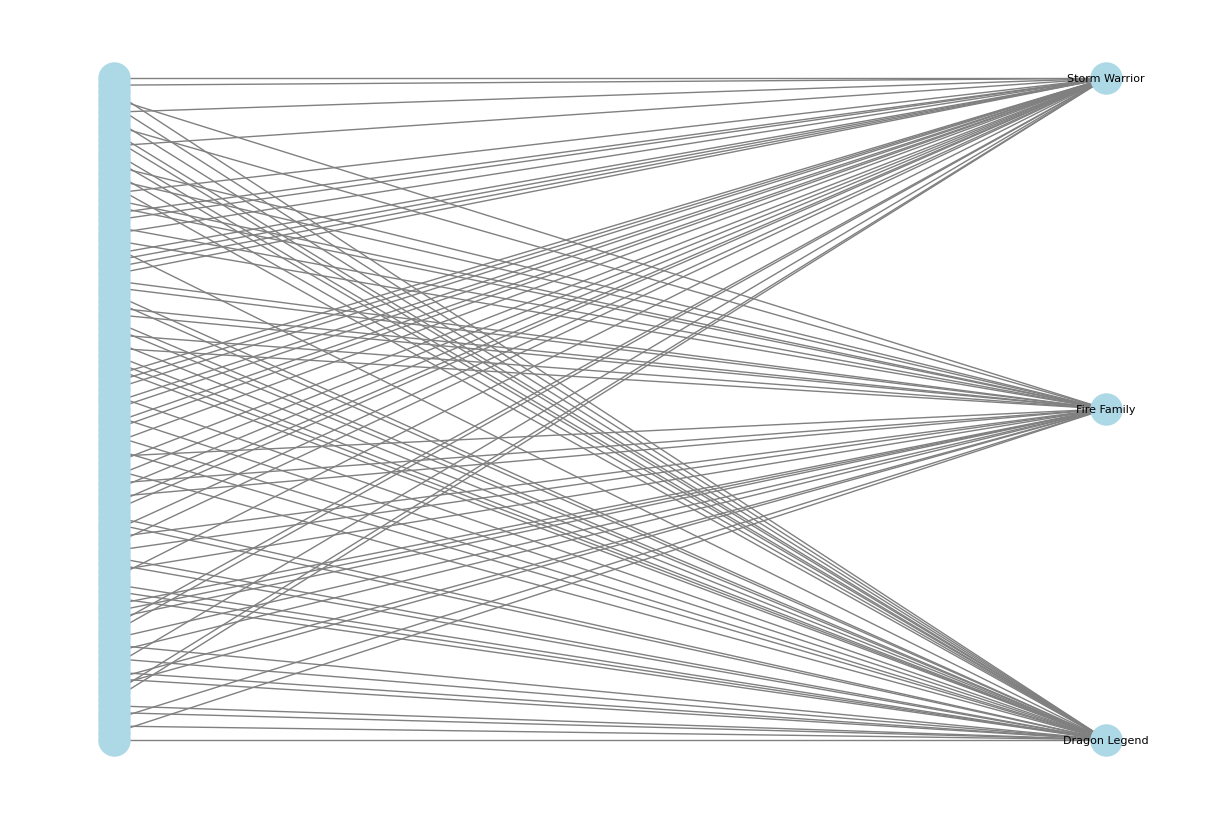

In [11]:
with driver.session() as session:
    result = session.run("""MATCH (a:User)-[r:WATCHED|RATED]->(b:Movie)
        RETURN a.ID as user, r, b.title as movie
        LIMIT 100
        """)
    edges = [(record["user"], record["movie"]) for record in result]
    # Build bipartite graph
    G = nx.Graph()
    for user, movie in edges:
    # Add user nodes with bipartite=0
        G.add_node(user, bipartite=0, label="User")
    # Add movie nodes with bipartite=1
        G.add_node(movie, bipartite=1, label="Movie")
    # Add edge
        G.add_edge(user, movie)
    
    # Separate node sets
    users = [u for u, v in edges]
    movies = [v for u, v in edges]

# Layout
pos = nx.bipartite_layout(G, users)

# Draw graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=500, node_color="lightblue", edge_color="gray")

# Add labels only on the right (movies)
movie_labels = {m: m for m in movies}
nx.draw_networkx_labels(G, pos, labels=movie_labels, font_size=8, font_color="black")

plt.axis("off")
plt.show()


### 3.4 🎬 User-Centric Exploration: Rated Movies

This query retrieves all the movies rated by a specific user (`user_07071`) and their corresponding ratings.  



In [12]:
with driver.session() as session:
    # list all the movies rated by user "user_07071"

    result = session.run("""
        MATCH (u:User{ID:"user_07071"})-[r:RATED]->(m:Movie)
        RETURN collect({title:m.title,rating:r.rating}) as RatingMovies, u.first_name as first_name, u.last_name as last_name
    """)
    record = result.single()
    if record:
        print(f'{record["first_name"]} {record["last_name"]} rated:')
        for mov in record["RatingMovies"]:
            print(f'{mov["title"]} {mov["rating"]}')
    else:
        print("No Movies")

Jon Elliott rated:
House Hero 5.0
Last Love 4.0
King Legend 3.0
Adventure Story 4.0


### 3.5 🎬 Movie-Centric Exploration

This query retrieves all the users who rated a specific movie (`An Legend`) and their corresponding ratings.  


In [13]:
with driver.session() as session:
    # list all the movies rated by user "An Legend"

    result = session.run("""
        MATCH (u:User)-[r:RATED]->(m:Movie{title:"An Legend"})
        RETURN collect({First_Name:u.first_name, Last_Name:u.last_name, rating:r.rating}) as RatingMovies, m.title as movie
    """)
    record = result.single()
    if record:
        print(f'Movie: {record["movie"]}')
        print("Users with reviews:")
        for user in record["RatingMovies"]:
            first = user["First_Name"]
            last = user["Last_Name"]
            print(f'-{first} {last} rated {user["rating"]}')
    else:
        print("No Movies")

Movie: An Legend
Users with reviews:
-Kristen Brown rated 4.0
-Joshua Thompson rated 3.0
-Sarah Roman rated 4.0
-Ricky Pruitt rated 1.0
-James Smith rated 5.0
-Jeanne Andrews rated 2.0
-Pamela Abbott rated 4.0
-Johnny Fuller rated 1.0
-Erica Lawson rated 5.0


## 4. Recommendation Models

#### 4.1 Recommendation Approaches
We implemented three main approaches for movie recommendations:  

- **Collaborative Filtering (CF):**  
  Recommend movies based on the behavior and preferences of other users.  
  - *User–User CF:* “Find people like me, then recommend what they liked.”  
  - *Example:* Recommend movies to `user_02434` based on the movies watched by users with similar watch history.  


In [14]:
with driver.session() as session:
    # recommend movies to "user_02434" based on the users watched the same movies as "user_02434"

    result = session.run("""
        MATCH (u:User{ID:"user_02434"})-[:WATCHED]->(:Movie)<-[:WATCHED]-(other:User)
        where other <> u 
        match(other:User)-[:WATCHED]->(mov:Movie)
        where NOT (u)-[:WATCHED]->(mov)
        RETURN distinct u.first_name as first_name, u.last_name as last_name, mov.title AS Movies, mov.imdb_rating AS rating 
        order by rating 
        limit 10
        """)
    record = list(result)
    if record:
        print(f'🎬 Suggested movies for {record[0]["first_name"]} {record[0]["last_name"]}')
        for r in record:
            print(f' - {r["Movies"]} (Rating: {r["rating"]})')
    else:
        print("No Movies")

🎬 Suggested movies for Brandon Hudson
 - Last Mission (Rating: 1.2)
 - Fire Warrior (Rating: 2.6)
 - Princess Adventure (Rating: 3.8)
 - My Journey (Rating: 3.9)
 - Phoenix Day (Rating: 4.1)
 - Mystery City (Rating: 4.3)
 - A Adventure (Rating: 4.4)
 - Fire Mystery (Rating: 4.4)
 - Fire Mystery (Rating: 4.6)
 - City Secret (Rating: 4.8)


- **Content-Based Filtering (CBF):**  
  Recommend movies similar to those a user has already liked, based on the feature "genre".  
  - *Example:* Recommend movies to `user_00436` based on genres matching the movies they have already watched.  



In [15]:
with driver.session() as session:
    # recommend movies to "user_00436" based on genres of movies matched by "user_00436" 

    result = session.run("""
        MATCH (u:User{ID:"user_00436"})-[r:RATED]->(mov)-[:BELONGS_TO]->(g:Genre)
        where r.sentiment IN ["positive","neutral"] 
        WITH u,g
        MATCH (mvs:Movie)-[:BELONGS_TO]->(g)
        WHERE NOT (u)-[:WATCHED]->(mvs)
        RETURN distinct u.first_name as first_name, u.last_name as last_name, 
        mvs.title AS Movies, mvs.imdb_rating AS rating 
        order by rating 
        limit 10
        """)
    record = list(result)
    if record:
        print(f'🎬 Suggested movies for {record[0]["first_name"]} {record[0]["last_name"]}')
        for r in record:
            print(f' - {r["Movies"]} (Rating: {r["rating"]})')
    else:
        print("No Movies")

🎬 Suggested movies for Erin Smith
 - Night House (Rating: 0.6)
 - House Fire (Rating: 0.8)
 - Mystery City (Rating: 4.3)
 - House Story (Rating: 4.6)
 - Fire Mystery (Rating: 4.6)
 - Dragon Ice (Rating: 4.7)
 - An Ice (Rating: 4.9)
 - Storm Empire (Rating: 4.9)
 - Last Quest (Rating: 5.0)
 - Dark Dragon (Rating: 5.2)


### 4.2 Graph-Based Recommendation Techniques
We leverage **Neo4j Graph Data Science (GDS)** algorithms for advanced recommendations:  

- **User–User Similarity Graph:**  
  Build a similarity graph between users and compute using:  
  - **Jaccard Similarity:** To measure overlap in watched movies between users.  


In [16]:
# Build similarity graph between users
with driver.session() as session:
    session.run("CALL gds.graph.drop('user-similarity-movie', false) YIELD graphName RETURN graphName")
    # Step 1: Create similarity graph projection
    session.run("""CALL gds.graph.project(
      'user-similarity-movie',
      ['User', 'Movie'],
      {
        WATCHED: {orientation:'UNDIRECTED'}
      }
        );
        """)
# Run Jaccard similarity between users
    result = session.run("""CALL gds.nodeSimilarity.stream('user-similarity-movie')
        YIELD node1, node2, similarity
        RETURN gds.util.asNode(node1).ID AS user1,
                gds.util.asNode(node1).first_name as user1_f_name,
                gds.util.asNode(node1).last_name as user1_l_name,
               gds.util.asNode(node2).ID AS user2,
               gds.util.asNode(node2).first_name as user2_f_name,
                gds.util.asNode(node2).last_name as user2_l_name,
               similarity
            ORDER BY similarity DESC
            LIMIT 10;
        """)
    records = [dict(record) for record in result]

    # First header row (main categories)
print(f"{'User1':<40}{'User2':<40}{'Similarity':<10}")
# Second header row (subdivisions)
print(f"{'ID':<12}{'First_Name':<15}{'Last_Name':<13}"
      f"{'ID':<12}{'First_Name':<15}{'Last_Name':<13}"
      f"{'':<10}")
print("-" * 95)

# Print rows
for r in records:
    print(f"{r['user1']:<12}{r['user1_f_name']:<15}{r['user1_l_name']:<13}"
          f"{r['user2']:<12}{r['user2_f_name']:<15}{r['user2_l_name']:<13}"
          f"{r['similarity']:<10.4f}")

User1                                   User2                                   Similarity
ID          First_Name     Last_Name    ID          First_Name     Last_Name              
-----------------------------------------------------------------------------------------------
user_00568  Karen          Walsh        user_07524  Haley          Crane        1.0000    
user_00565  Matthew        Jones        user_03025  Mark           Jones        1.0000    
user_00547  Mackenzie      Miller       user_02938  Cheryl         Clark        1.0000    
user_00565  Matthew        Jones        user_05281  Kaylee         Mercer       1.0000    
user_00565  Matthew        Jones        user_09572  Eduardo        Figueroa     1.0000    
user_00565  Matthew        Jones        user_05465  Robert         Winters      1.0000    
user_00529  Lisa           Lane         user_02647  Bruce          Wilkins      1.0000    
user_00547  Mackenzie      Miller       user_09587  Steven         Jackson      1.000

- A specific example for **User–User Similarity Graph:**  
  - Build a similarity graph between a specific user (`user_00436`) and compute **Jaccard Similarity** to measure overlap in watched movies between users.  
  - This approach helps recommend movies for `user_00436` based on the preferences of the most similar users.  

---


In [17]:
#User–User CF: “Find people like me, then recommend what they liked.”
similarities = [] 
#Recommendation for a secific user based on user-user node similarity
with driver.session() as session:
    session.run("CALL gds.graph.drop('UserMovieGraph', false) YIELD graphName ")
    session.run("""CALL gds.graph.project(
  'UserMovieGraph',
  ['User', 'Movie'],
  {RATED: {orientation: 'UNDIRECTED',
          properties: 'rating'}
  
  }
  );
    """)
    result = session.run("""
        MATCH (u:User{ID:"user_00436"})
        CALL gds.nodeSimilarity.stream('UserMovieGraph')
        YIELD node1,node2, similarity
        WHERE gds.util.asNode(node1).ID = "user_00436"
               OR gds.util.asNode(node2).ID = "user_00436"
       RETURN gds.util.asNode(node1).first_name AS user1, 
            gds.util.asNode(node2).first_name AS user2, 
            similarity
        ORDER BY similarity DESC LIMIT 10;
        """)
    for record in result:
        user1 = record['user1'] if record['user1'] is not None else "N/A"
        user2 = record['user2'] if record['user2'] is not None else "N/A"
        similarity = record['similarity'] if record['similarity'] is not None else 0.0
        print(f"{user1:<30} {user2:<30}{similarity:.4f}")
        similarities.append({
            "user1": record["user1"],
            "user2": record["user2"],
            "similarity": record["similarity"]
        })

# Convert to DataFrame for later use
similarity_df = pd.DataFrame(similarities)
#display(similarity_df)
    


Erin                           Kelsey                        1.0000
Erin                           Steven                        1.0000
Steven                         Erin                          1.0000
Kelsey                         Erin                          1.0000
Erin                           Ricardo                       0.5000
Erin                           Jason                         0.5000
Erin                           Clifford                      0.5000
Erin                           Janet                         0.5000
Erin                           Raymond                       0.5000
Erin                           Emily                         0.5000


In [18]:
target_user = "user_00436"
similar_users = similarity_df["user2"].tolist()  # take all similar users

with driver.session() as session:
    result = session.run("""
        MATCH (u:User)-[r:RATED]->(m:Movie)
        WHERE u.first_name IN $similar_users
          AND NOT ( (u:User{ID:$target_user})-[:RATED]->(m) )
        RETURN m.title AS movie, avg(r.rating) AS avg_rating
        ORDER BY avg_rating DESC LIMIT 10
    """, {"similar_users": similar_users, "target_user": target_user})

    for record in result:
        print(f"{record['movie']}   Avg rating: {record['avg_rating']:.2f}")

    

Last Love   Avg rating: 5.00
War Phoenix   Avg rating: 5.00
Day Fire   Avg rating: 5.00
Fire Mystery   Avg rating: 5.00
Mystery Storm   Avg rating: 5.00
The Mystery   Avg rating: 5.00
Journey Mystery   Avg rating: 5.00
Night Night   Avg rating: 5.00
Quest Princess   Avg rating: 5.00
Quest Secret   Avg rating: 5.00


 **Specific User Recommendation (Node Similarity):**  
  Example Cypher query for finding similar movies to those watched by `user_01536`:  



In [19]:
with driver.session() as session:
    result = session.run("""CALL gds.nodeSimilarity.stream('UserMovieGraph')
        YIELD node1, node2, similarity
        WITH gds.util.asNode(node1) AS n1, gds.util.asNode(node2) AS n2, similarity
        WHERE n1:Movie AND n2:Movie AND elementId(n1) < elementId(n2)
          AND (
            EXISTS { MATCH (:User {ID:"user_01536"})-[:WATCHED]->(n1) }
            OR
            EXISTS { MATCH (:User {ID:"user_01536"})-[:WATCHED]->(n2) }
          )
          RETURN n1.title AS movie1,
               n2.title AS movie2,
               similarity
        ORDER BY similarity DESC
        LIMIT 10;
            """)
    #for res in result:
     #   print(f'{res["movie1"]}\t {res["movie2"]}\t {res["similarity"]}')
    similar_movies = [] 
    for res in result:
        movie1=res["movie1"]
        movie2=res["movie2"]
        watched_res = session.run("""
        MATCH(u:User{ID:$user_id})
        return exists ((u)-[:WATCHED]->(:Movie{title:$title}) ) as watched
             """, user_id = "user_01536", title=movie1)
        watched = watched_res.single()["watched"]
        if watched:
            similar_movies.append(movie2)
        else:
            similar_movies.append(movie1)
    print(similar_movies)   
    

['Day Fire', 'Phoenix Dragon', 'Battle Ice', 'Kingdom Kingdom', 'King House', 'Big Story', 'Mission Empire', 'Secret Hero', 'City Fire', 'Quest Hero']


- **PageRank:** To identify influential or popular movies in the network.  

In [20]:
with driver.session() as session:
    session.run("CALL gds.graph.drop('movieGraph', false) YIELD graphName RETURN graphName")
    session.run("""CALL gds.graph.project(
  'movieGraph',
  ['User', 'Movie'],
  {WATCHED: {orientation: 'UNDIRECTED'}}
    );
    """)
    result = session.run("""CALL gds.pageRank.stream('movieGraph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).title AS movie, score
        ORDER BY score DESC LIMIT 10;
        """)
    print("Top 10 Movies by PageRank")
    print("-" * 40)
    for record in result:
        print(f"{record['movie']:<30} {record['score']:.4f}")

Top 10 Movies by PageRank
----------------------------------------
Kingdom Princess               8.8818
War Queen                      8.2503
An Fire                        7.9473
Love War                       7.4647
Our Battle                     7.4442
Big Queen                      7.1985
Legend Legend                  7.0840
Empire Mystery                 7.0130
Adventure Mission              6.9994
War Hero                       6.9112


- **Community Detection (Louvain):**  
     Cluster users into communities based on shared movie preferences, and recommend popular movies within the same community.


Graph with 989 nodes and 1000 edges
Users: 963, Movies: 26


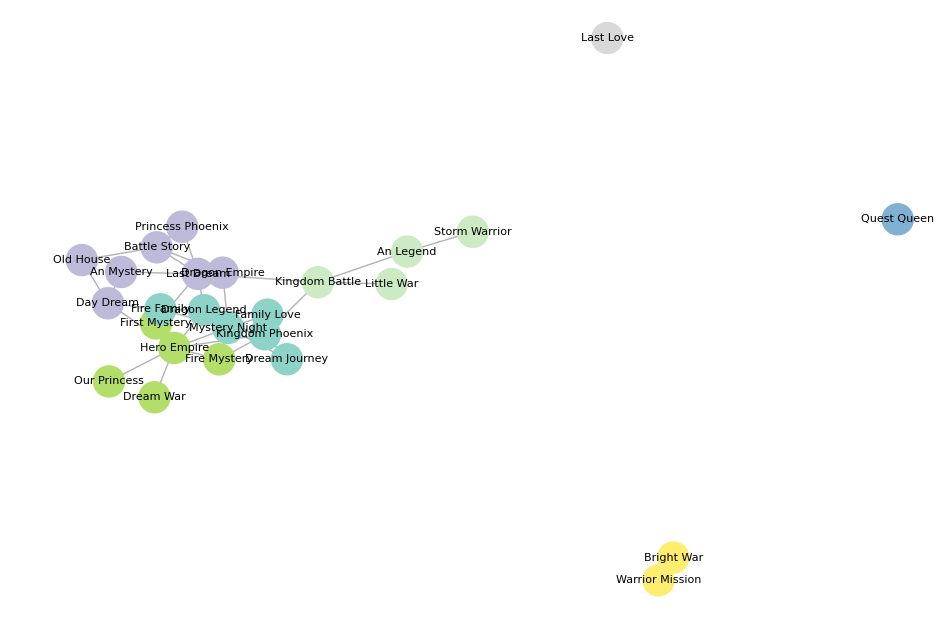

In [21]:
import community.community_louvain as community_louvain
with driver.session() as session:
    result = session.run("""MATCH (a:User)-[r:WATCHED|RATED]->(b:Movie)
        RETURN a.ID as user, r, b.title as movie
        LIMIT 1000
        """)
    edges = [(record["user"], record["movie"]) for record in result]
    
    G = nx.Graph()
    for user, movie in edges:
        G.add_node(user, bipartite=0, label="User")
        G.add_node(movie, bipartite=1, label="Movie")
        G.add_edge(user, movie)

users = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
movies = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}
print(G)
print(f"Users: {len(users)}, Movies: {len(movies)}")

movie_graph = nx.bipartite.weighted_projected_graph(G, movies)

# Apply Louvain community detection
partition = community_louvain.best_partition(movie_graph, weight='weight')

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(movie_graph, seed=42)

colors = [partition[node] for node in movie_graph.nodes()]
nx.draw_networkx_nodes(movie_graph, pos, node_size=500, node_color=colors, cmap=plt.cm.Set3)
nx.draw_networkx_edges(movie_graph, pos, alpha=0.3)
nx.draw_networkx_labels(movie_graph, pos, font_size=8)

plt.axis("off")
plt.show()


## 5. 📖 Conclusion  

In this notebook, we built a **graph-based recommendation system** using Neo4j Graph Data Science (GDS) on a Netflix-like dataset.  

- We constructed a **user–movie–genre graph** from raw CSV files.  
- Using **PageRank**, we identified influential movies within the network.  
- With **Node Similarity (Jaccard)**, we detected users and movies with overlapping preferences.  
- Through **Link Prediction**, we forecasted potential future interactions between users and movies.  

Compared to traditional collaborative filtering, the graph-based approach captures **indirect relationships** and provides more **explainable recommendations** by leveraging the underlying network structure.  
This demonstrates the power of graph analytics for modern recommendation engines.


## 6. 🚀 Future Work  

This project opens several directions for further exploration:  

1. **Scalability** → Apply the pipeline to larger real-world datasets and explore distributed Neo4j or Spark GraphFrames for big data.  
2. **Hybrid Models** → Combine graph-based methods with **deep learning** (e.g., Graph Neural Networks) for richer embeddings and more accurate recommendations.  
3. **Evaluation Metrics** → Incorporate ranking metrics like **NDCG, MAP, and Hit-Rate** to benchmark recommendation quality.  
4. **Cold-Start Problem** → Integrate **content-based features** (movie metadata, genres, cast, descriptions) to recommend items to new users.  
5. **Personalization & Context Awareness** → Extend the system to include factors like **time of viewing, user demographics, or device type**.  
6. **Visualization Dashboards** → Build interactive dashboards using **Neo4j Bloom** or Python libraries like **Dash/Plotly** for better exploration of recommendations.  

By pursuing these improvements, the system can evolve into a production-ready, scalable, and highly personalized recommendation engine.


In [ ]:
driver.close()